In [1]:
!pip install pandas
!pip install nltk

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords    
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer

data = pd.read_csv("C:\\Users\\ruet\\UpdatedResumeDataSet.csv")

# Lowercase korsi Resume string ke uniform letter a niye ashar jonno
data['Resume'] = data['Resume'].str.lower()
label = data['Category']

# NLTK's stopwords and lemmatizer ke initialize korlam jehetu stopwords gula baad dile valo result ase.
# ebong limmatized korsi karon uniform shape a word gulake rakhte ,etaw result a valo effect rakhe.. 
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#'Resume' column ke lemmatization kora and stopwords remove korar process.
def preprocess_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # word ta stopword na holei lemmatized korte hbe
    return ' '.join(words)

data['Resume'] = data['Resume'].apply(preprocess_text)  # Resume ke preprocess er jonno preprocess-text function call korsi

# <OOV> set korar karon corpus a kono ekta data na pele,oi data <OOV> dara replace hbe.
tokenizer = Tokenizer(oov_token='<OOV>')


documents = data['Resume']
tokenizer.fit_on_texts(documents) # lemmatized string take tokenizer er moddhe fit korsi.

word_index = tokenizer.word_index
dataSeqs = tokenizer.texts_to_sequences(documents)# lemmatized documents/text ke sequences a convert korar process

# Print the word index
print(word_index)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'<OOV>': 1, 'â\x80¢': 2, 'project': 3, 'exprience': 4, 'company': 5, 'month': 6, 'description': 7, 'detail': 8, '1': 9, 'data': 10, 'team': 11, 'management': 12, 'skill': 13, 'system': 14, '6': 15, 'year': 16, 'maharashtra': 17, 'database': 18, 'testing': 19, 'client': 20, 'test': 21, 'business': 22, 'application': 23, 'le': 24, 'development': 25, 'technology': 26, 'ltd': 27, 'service': 28, 'developer': 29, 'using': 30, 'sql': 31, 'january': 32, 'java': 33, 'customer': 34, 'engineering': 35, 'work': 36, 'pune': 37, 'process': 38, 'report': 39, 'server': 40, 'requirement': 41, 'c': 42, 'role': 43, 'â\x9e¢': 44, 'software': 45, 'pvt': 46, 'education': 47, 'design': 48, '2': 49, 'technical': 50, 'university': 51, 'user': 52, 'environment': 53, 'india': 54, 'monthscompany': 55, 'working': 56, 'various': 57, 'operation': 58, 'm': 59, 'web': 60, 'engineer': 61, 'python': 62, 'college': 63, 'sale': 64, 'time': 65, 's': 66, 'manager': 67, 'job': 68, 'automation': 69, 'â': 70, 'like': 71, 'act

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = max([len(doc) for doc in dataSeqs])  # dataSeqs er moddhe jeitar element beshi tar numb.
print(maxlen)

# sequences gulake uniform shape niye asha jate machine ke train korano kono jhamela na hoy.
paddedSequences = pad_sequences(dataSeqs,padding = 'post',truncating = 'post', maxlen=maxlen)
print(paddedSequences) 

# numpy array te converting
data = np.array(paddedSequences)
labels = np.array(label)
label=labels

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False) # class gula jehetu string tai oneHotEncoding kora

class_labels = label.reshape((label.shape[0], 1))  #label gulake ekta coloumn a rakha
labels = encoder.fit_transform(class_labels)  # class gula jehetu string tai oneHotEncoding kora



1697
[[  13  228  401 ...    0    0    0]
 [  47    8  266 ...    0    0    0]
 [ 272 1022  766 ...    0    0    0]
 ...
 [ 317   13    2 ...    0    0    0]
 [  87   13   45 ...    0    0    0]
 [  13  332  585 ...    0    0    0]]


C:\Users\ruet\miniconda3\envs\tf-env-2\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
from sklearn.model_selection import train_test_split

trainData,testData,trainLabels,testLabels =train_test_split(data,labels,test_size=0.3,random_state=42)
valData,testData,valLabels,testLabels =train_test_split(testData,testLabels,test_size=0.5,random_state=42)



In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [10]:
import tensorflow as tf

embedding_dim = 600
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(word_index) + 1,
                              output_dim=embedding_dim,
                              input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),   # dropout overfitting prevent korar jonno
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),  # dropout overfitting prevent korar jonno

    tf.keras.layers.Dense(25, activation='softmax')  # multi-classification tai softmax
])

model.compile(loss='categorical_crossentropy',  #categorical_crossentropy karon multiclass and labels gulake OneHotEncoding kora hoyese.
              optimizer='adam',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Use validation_split to allocate a portion of training data for validation
num_epochs = 30
history = model.fit(trainData, trainLabels, epochs=num_epochs,
                    validation_data=(valData, valLabels),
                    callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(patience=4)],# Early Stopping karon overfitting prevent kora lage
                    verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(testData, testLabels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Epoch 1/30
22/22 - 15s - loss: 3.1004 - accuracy: 0.1189 - val_loss: 2.7452 - val_accuracy: 0.3125 - 15s/epoch - 671ms/step
Epoch 2/30
22/22 - 9s - loss: 2.2797 - accuracy: 0.4250 - val_loss: 1.8928 - val_accuracy: 0.5694 - 9s/epoch - 428ms/step
Epoch 3/30
22/22 - 9s - loss: 1.4649 - accuracy: 0.6954 - val_loss: 1.3164 - val_accuracy: 0.7361 - 9s/epoch - 431ms/step
Epoch 4/30
22/22 - 10s - loss: 0.9133 - accuracy: 0.8410 - val_loss: 0.8237 - val_accuracy: 0.8333 - 10s/epoch - 438ms/step
Epoch 5/30
22/22 - 9s - loss: 0.5345 - accuracy: 0.9242 - val_loss: 0.4983 - val_accuracy: 0.9306 - 9s/epoch - 424ms/step
Epoch 6/30
22/22 - 9s - loss: 0.3640 - accuracy: 0.9525 - val_loss: 0.3357 - val_accuracy: 0.9722 - 9s/epoch - 412ms/step
Epoch 7/30
22/22 - 9s - loss: 0.2178 - accuracy: 0.9896 - val_loss: 0.2482 - val_accuracy: 0.9861 - 9s/epoch - 412ms/step
Epoch 8/30
22/22 - 9s - loss: 0.1416 - accuracy: 1.0000 - val_loss: 0.1917 - val_accuracy: 0.9722 - 9s/epoch - 409ms/step
Epoch 9/30
22/22 - 9

In [11]:
from sklearn.metrics import classification_report

# Assuming your model's predictions are stored in 'predictions'
predictions = model.predict(testData)

# Convert probabilities to class predictions (assuming binary classification)
predicted_classes = (predictions > 0.5).astype(int)

# Generate classification report
report = classification_report(testLabels, predicted_classes)
print(report)


5/5 [==============================] - 2s 149ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00        13
          16       1.00     

In [12]:
!pip install seaborn


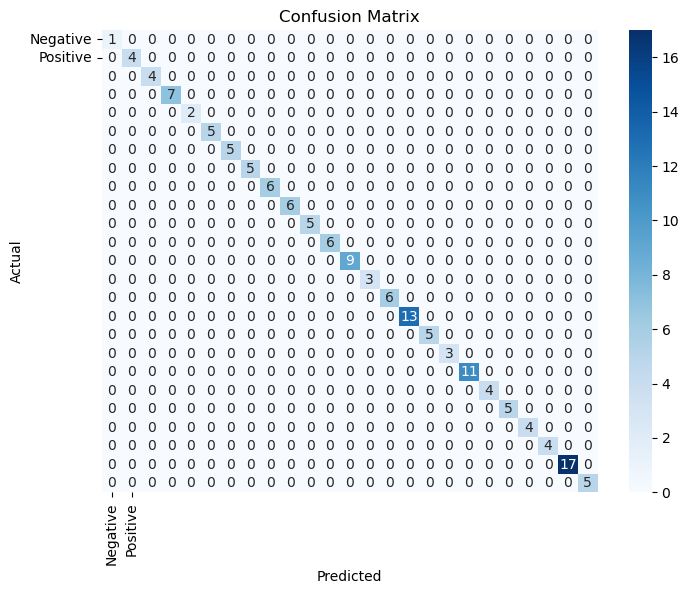

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert one-hot encoded labels to class labels (0 or 1)
testLabels_binary = np.argmax(testLabels, axis=1)
predicted_classes_binary = np.argmax(predicted_classes, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(testLabels_binary, predicted_classes_binary)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


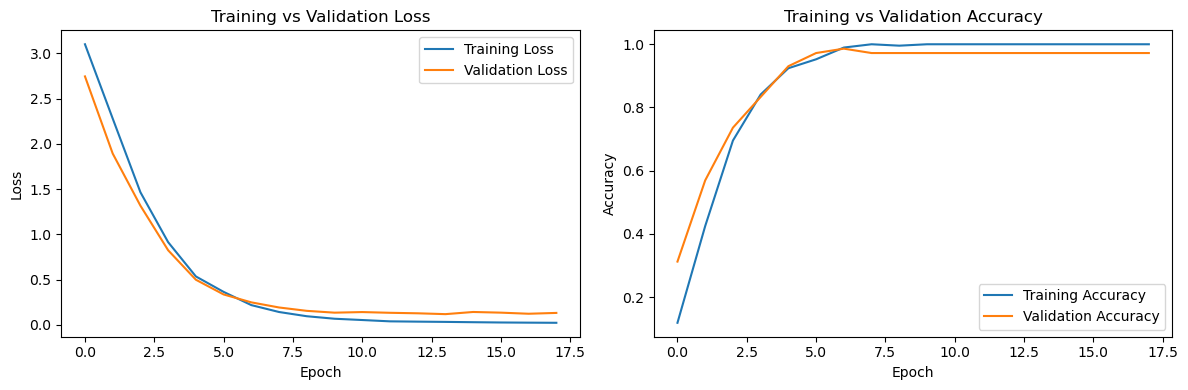

In [14]:
import matplotlib.pyplot as plt


# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
model.save("C:\\Users\\ruet\\UpdatedResume.h5py")

INFO:tensorflow:Assets written to: C:\Users\ruet\UpdatedResume.h5py\assets


INFO:tensorflow:Assets written to: C:\Users\ruet\UpdatedResume.h5py\assets


In [17]:
import pickle


# Save the history using pickle
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [18]:

# Load the history from the saved file
with open('training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

    